In [1]:
import os
import yaml
import argparse
import torch
import numpy as np
import data_utils.data_loaders as module_data
import metrics.loss as module_loss
import metrics.metric as module_metric
import models
from trainer import Trainer
from utils import Logger

from data_utils import JointsActionDataLoader, CollateJointsSeqBatch, DepthJointsDataLoader,\
                       PersistentDataLoader
from models import BaselineHARModel, DeepPriorPPModel


from torchvision import datasets, transforms
#from torch.utils.data.dataloader import default_collate

from datasets import BaseDataType, HandPoseActionDataset, \
                     FHADCameraIntrinsics, DepthParameters, \
                     MSRACameraIntrinsics, MSRAHandDataset


from data_utils.data_loaders import *

from data_utils.data_loaders import _check_pca
from data_utils._dp_transformers import DeepPriorXYTransform

from tqdm import tqdm_notebook as tqdm_nb


In [2]:
class DepthJointsDataLoaderDebug(BaseDataLoader):
    '''

    '''

    def __init__(self, data_dir, dataset_type, batch_size, shuffle, pca_components=30,
                validation_split=0.0, num_workers=1, debug=False, reduce=False,
                test_mm_err=False,
                use_pca_cache=True, pca_overwrite_cache=False, preload_depth=False,
                use_msra=False, data_aug=None, pca_data_aug=None):
        '''
            preload depth is not really needed, pytorch is intelligent and after
            first epoch everything is preloaded i.e. shared memory is used for
            dataset because training after first epoch is much faster
            even without preloading
        '''
        if use_msra:
            print("WARNING: USING MSRA DATASET")
            print("Several settings will be overidden")
            data_dir = '../deep-prior-pp-pytorch/datasets/MSRA15'
            pca_overwrite_cache = True#True # ensure correct cache is calculated


        t = time.time()

        ## load pca if overwrite is false and use_cache is true
        ## doesn't distinguish between msra and fhad, just loads
        pca_transformer = PCATransformer(n_components=pca_components,
                                         use_cache=use_pca_cache,
                                         overwrite_cache=pca_overwrite_cache)
        
        #not needed atm as NLLloss needs only class idx
        #ActionOneHotEncoder(action_classes=45)
        trnsfrm_base_params = {
            'num_joints': 21,
            'world_dim': 3,
            'cube_side_mm': 200,
            'debug_mode': debug,
            'cam_intrinsics': FHADCameraIntrinsics if not use_msra else MSRACameraIntrinsics,
            'dep_params': DepthParameters
        }


        ### train transformers ###
        train_transform_list = [
            JointReshaper(**trnsfrm_base_params),
            DepthCropper(**trnsfrm_base_params),
        ]

        if data_aug is not None and isinstance(data_aug, list):
            train_aug_list = list(map(lambda i: AugType(i), data_aug))
            train_transform_list.append(
                DepthAndJointsAugmenter(aug_mode_lst=train_aug_list,**trnsfrm_base_params),
            )
            print("Using data augmentation %a for training..." % train_aug_list)

        train_transform_list += [
            DepthStandardiser(**trnsfrm_base_params),
            JointCentererStandardiser(**trnsfrm_base_params),
            pca_transformer,
            ToTuple(extract_type='depth_joints')
        ]


        if dataset_type == 'train':
            trnsfrm = transforms.Compose(train_transform_list)
        elif dataset_type == 'test':
            raise NotImplementedError("Not Implemented")
        
        
        
        ### pca transformers ###
        pca_trnsfrm_list = [JointReshaper(**trnsfrm_base_params), DepthCropper(**trnsfrm_base_params)]
        if pca_data_aug is not None and isinstance(pca_data_aug, list):
            pca_aug_list = list(map(lambda i: AugType(i), pca_data_aug))
            pca_trnsfrm_list.append(
                DepthAndJointsAugmenter(aug_mode_lst=pca_aug_list,**trnsfrm_base_params),
            )
            print("Using data augmentation %a for pca (if cache overwrite is true)..." % pca_aug_list)
        pca_trnsfrm_list += [JointCentererStandardiser(**trnsfrm_base_params), ToTuple(extract_type='joints')]
        pca_trnsfrms = transforms.Compose(pca_trnsfrm_list)
        
        
        ### datasets ###
        if use_msra:
            self.dataset = MSRAHandDataset(root=data_dir, center_dir='', mode=dataset_type, 
                                           test_subject_id=0, transform=trnsfrm, reduce=reduce,
                                           use_refined_com=False)
        else:
            self.dataset = HandPoseActionDataset(data_dir, dataset_type, 'hpe',
                                                 transform=trnsfrm, reduce=reduce,
                                                 retrieve_depth=True, preload_depth=preload_depth)

        ### before exiting ensure PCA is pre-computed (using cache on disk)
        ### for train: used as pre-processing
        ### for test: pca matx and mean is used for weights, bias as last layer
        self.pca_weights_np, self.pca_bias_np = _check_pca(data_dir, pca_transformer, pca_trnsfrms,
                                                           trnsfrm_base_params, use_msra=use_msra,
                                                           y_pca_len=200000) # 10000
        
        #print("ITEM_X:\n", list(self.dataset[0][0][0, 64,:]))
        #quit()

        self.params = trnsfrm_base_params
        self.params['pca_components'] = pca_components
        

        ## initialise super class appropriately
        super(DepthJointsDataLoaderDebug, self).\
            __init__(self.dataset, batch_size, shuffle, validation_split, num_workers,
                     collate_fn=CollateDepthJointsBatch())

        if debug:
            print("Data Loaded! Took: %0.2fs" % (time.time() - t))
            test_sample = self.dataset[0]
            print("Sample Final Shape: ", test_sample[0].shape, test_sample[1].shape)
            print("Sample Final Values:\n", test_sample[0], "\n", test_sample[1])
            print("Sample Joints_Std_MIN_MAX: ", test_sample[0].min(), test_sample[0].max())

            

def dataset2arrays(dataset):
    inputs = np.zeros((len(dataset), *dataset[0][0].shape))
    outputs = np.zeros((len(dataset), *dataset[0][1].shape))

    for i in tqdm(range(len(dataset)), desc='Loading Dataset'):
            item = dataset[i]
            inputs[i] = item[0]
            outputs[i] = item[1]
    return inputs, outputs

In [ ]:
## note cache in use here!

## NOTE USE MSRA IS SET TO FALSE

debug_dataloader = \
    DepthJointsDataLoaderDebug(batch_size=128, shuffle=False, data_dir='datasets/hand_pose_action', dataset_type='train', 
                           debug=True, num_workers=8, pca_components=30,
                           pca_data_aug=[AugType.AUG_ROT, AugType.AUG_SC, AugType.AUG_TRANS], 
                           data_aug=[AugType.AUG_ROT, AugType.AUG_SC, AugType.AUG_TRANS], pca_overwrite_cache=True,
                           reduce=False, use_msra=False, use_pca_cache=True,
                           validation_split=0.0)

dataloader2 = \
    DepthJointsDataLoaderDebug(batch_size=128, shuffle=False, data_dir='datasets/hand_pose_action', dataset_type='train', 
                           debug=False, num_workers=8, pca_components=30,
                           pca_data_aug=[AugType.AUG_ROT, AugType.AUG_SC, AugType.AUG_TRANS], 
                           data_aug=[AugType.AUG_ROT, AugType.AUG_SC, AugType.AUG_TRANS], pca_overwrite_cache=False,
                           reduce=False, use_msra=False, use_pca_cache=True,
                           validation_split=0.0)

In [ ]:
### setup dataloaders ###
data_dir = 'datasets/hand_pose_action' #'../deep-prior-pp-pytorch/datasets/MSRA15'
data_aug = [AugType.AUG_NONE]

crop_depth_ver = 2
crop_pad_3d = [30., 30., 100.]
crop_pad_2d = [40, 40, 100.]
cube_side_mm = 200

trnsfrm_base_params = {
        'num_joints': 21,
        'world_dim': 3,
        'cube_side_mm': cube_side_mm, #230, #200, ## this is the main issue here!
        'debug_mode': False, #True,
        'cam_intrinsics': FHADCameraIntrinsics, #MSRACameraIntrinsics,
        'dep_params': DepthParameters,
        'aug_lims': Namespace(scale_std=0.02, trans_std=5, abs_rot_lim_deg=180),
        'crop_pad': tuple(crop_pad_3d) if crop_depth_ver <= 1 else tuple(crop_pad_2d),
        'crop_depth_ver': 2, #crop_depth_ver,
        'debug_mode': False,
}


trnsfrm_msra_params = {
        'num_joints': 21,
        'world_dim': 3,
        'cube_side_mm': 200, #230, #200, ## this is the main issue here!
        'debug_mode': False, #True,
        'cam_intrinsics': MSRACameraIntrinsics,
        'dep_params': DepthParameters,
        'crop_pad': tuple(crop_pad_3d) if crop_depth_ver <= 1 else tuple(crop_pad_2d),
        'crop_depth_ver': 0, #crop_depth_ver,
        'debug_mode': False,
}

# old_transforms = transforms.Compose([
#             DeepPriorXYTransform(aug_mode_lst=data_aug),
#             ToTuple(extract_type='depth_joints'),
# ])
old_transforms = transforms.Compose([
            JointReshaper(**trnsfrm_msra_params),
            DepthCropper(**trnsfrm_msra_params),
            DepthAndJointsAugmenter(aug_mode_lst=data_aug,**trnsfrm_msra_params),
            DepthStandardiser(**trnsfrm_msra_params),
            JointCentererStandardiser(**trnsfrm_msra_params),
            ToTuple(extract_type='depth_joints'), #depth_joints
])
new_transforms = transforms.Compose([
            JointReshaper(**trnsfrm_base_params),
            DepthCropper(**trnsfrm_base_params),
            DepthAndJointsAugmenter(aug_mode_lst=data_aug,**trnsfrm_base_params),
            DepthStandardiser(**trnsfrm_base_params),
            #JointCentererStandardiser(**trnsfrm_base_params),
            ToTuple(extract_type='depth_joints_debug'), #depth_joints
])
old_dataset_obj_no_aug = MSRAHandDataset(root='../deep-prior-pp-pytorch/datasets/MSRA15', center_dir='', mode='train', 
                                           test_subject_id=0, transform=old_transforms, reduce=False,
                                           use_refined_com=False)
new_dataset_obj_no_aug = HandPoseActionDataset(data_dir, 'train', 'hpe',
                                                 transform=new_transforms, reduce=False,
                                                 retrieve_depth=True, preload_depth=False)

### load_data ###
old_inputs, old_outputs = dataset2arrays(old_dataset_obj_no_aug)
new_inputs, new_outputs = dataset2arrays(new_dataset_obj_no_aug)

[DEPTH&JOINTAUG] Crop_Shape: (200, 200, 200)
[DEPTHCROPPER] Using ver.2 depth cropping with (40, 40, 100.0) padding
[DEPTH&JOINTAUG] Crop_Shape: (200, 200, 200)
[MSRA] Train Size: 67876 Test Size:  8499 Mode: train


Internal Python error in the inspect module.
Below is the traceback from this internal error.

Internal Python error in the inspect module.
Below is the traceback from this internal error.

Internal Python error in the inspect module.
Below is the traceback from this internal error.

Invalid alias: The name clear can't be aliased because it is another magic command.
Invalid alias: The name more can't be aliased because it is another magic command.
Invalid alias: The name less can't be aliased because it is another magic command.
Invalid alias: The name man can't be aliased because it is another magic command.


#### Test 1: Max/Min of Skeleton Data

Here we consider Max/Min amongst all three axis: x, y and z

In future we should only consider x, y

Note: All values represent mm directly (px conversions only used for cropping and data aug)!

In [ ]:
#### data testing ####

### Test Max/Min Value of Skeleton
### Expect: Max <= 1; Min >= -1
print("Outputs Shape: ", old_outputs.shape, new_outputs.shape)
new_outputs = new_outputs.reshape(-1, 63)


#old_outputs_xy = old_outputs[:, :2]
out_old_max, out_old_argmax = old_outputs.max(axis=1).max(), old_outputs.max(axis=1).argmax()
out_old_min, out_old_argmin = old_outputs.min(axis=1).min(), old_outputs.min(axis=1).argmin()

#new_outputs_xy = new_outputs[:, :2]
out_new_max, out_new_argmax = new_outputs.max(axis=1).max(), new_outputs.max(axis=1).argmax()
out_new_min, out_new_argmin = new_outputs.min(axis=1).min(), new_outputs.min(axis=1).argmin()

print("Old Outputs Max/Min: ", out_old_max, out_old_min)
print("Old Outputs Max/Min: ", out_new_min, out_new_argmin)

old_dataset_obj_no_aug.transform.transforms[2].debug_mode = True
new_dataset_obj_no_aug.transform.transforms[2].debug_mode = True

print("\nOld Output Max/Min Plots -->")
old_dataset_obj_no_aug[out_old_argmax]
old_dataset_obj_no_aug[out_old_argmin]

print("\nNew Output Max/Min Plots -->")
new_dataset_obj_no_aug[out_new_argmax]
new_dataset_obj_no_aug[out_new_argmin]

In [41]:
### Test 2 Rotational Tests

#### data loading ####
data_aug = [AugType.AUG_ROT]
old_transforms = transforms.Compose([
            DeepPriorXYTransform(aug_mode_lst=data_aug),
            ToTuple(extract_type='depth_joints'),
])
new_transforms = transforms.Compose([
            JointReshaper(**trnsfrm_base_params),
            DepthCropper(**trnsfrm_base_params),
            DepthAndJointsAugmenter(aug_mode_lst=data_aug,**trnsfrm_base_params),
            DepthStandardiser(**trnsfrm_base_params),
            JointCentererStandardiser(**trnsfrm_base_params),
            ToTuple(extract_type='depth_joints'),
])
old_dataset_obj_no_aug = MSRAHandDataset(root=data_dir, center_dir='', mode='train', 
                                           test_subject_id=0, transform=old_transforms, reduce=False,
                                           use_refined_com=False)
new_dataset_obj_no_aug = MSRAHandDataset(root=data_dir, center_dir='', mode='train', 
                                           test_subject_id=0, transform=new_transforms, reduce=False,
                                           use_refined_com=False)

### load_data ###
old_inputs, old_outputs = dataset2arrays(old_dataset_obj_no_aug)
new_inputs, new_outputs = dataset2arrays(new_dataset_obj_no_aug)


Train/Test: 67876 8499
Train/Test: 67876 8499


Loading dataset: 100%|██████████| 67876/67876 [04:12<00:00, 268.71it/s]


Outputs Shape:  (67876, 63) (67876, 63)
Old Outputs Max/Min:  1.1295464038848877 -1.1594287157058716
New Outputs Max/Min:  1.1123661994934082 -1.2839114665985107

Old Output Max/Min Plots -->

Com_Orig:  [185.12015 104.90141 341.886  ] 
Com_Crop:  [ 63.206894  63.911133 341.886   ] 
Com_Crop_Aug:  [ 63.886303  63.210068 341.886   ] 
KeyPt_Crop_Aug_XY: Max => 73.78, Min => -3.39



Com_Orig:  [161.38469 104.64351 347.284  ] 
Com_Crop:  [ 63.893814  64.13216  347.284   ] 
Com_Crop_Aug:  [ 64.15102  63.92296 347.284  ] 
KeyPt_Crop_Aug_XY: Max => 93.68, Min => -1.36



New Output Max/Min Plots -->

Com_Orig:  [182.98578 102.76593 342.622  ] 
Com_Crop:  [ 63.533188  64.24141  342.622   ] 
Com_Crop_Aug:  [ 64.45855   63.743233 342.622   ] 
KeyPt_Crop_Aug_XY: Max => 94.76, Min => -2.86


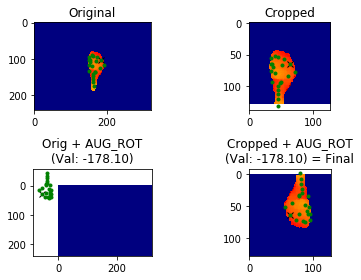


Com_Orig:  [140.7258  130.31953 300.329  ] 
Com_Crop:  [ 64.17952   63.856525 300.329   ] 
Com_Crop_Aug:  [ 64.22748  64.03261 300.329  ] 
KeyPt_Crop_Aug_XY: Max => 107.00, Min => 37.22


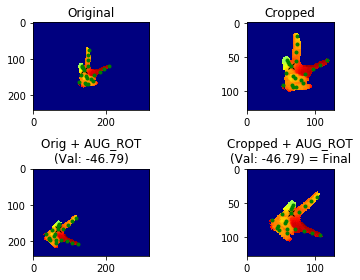

(array([[[0.66593635, 0.66593635, 0.66593635, ..., 0.66593635,
          0.66593635, 0.66593635],
         [0.66593635, 0.66593635, 0.66593635, ..., 0.66593635,
          0.66593635, 0.66593635],
         [0.66593635, 0.66593635, 0.66593635, ..., 0.66593635,
          0.66593635, 0.66593635],
         ...,
         [0.66593635, 0.66593635, 0.66593635, ..., 0.66593635,
          0.66593635, 0.66593635],
         [0.66593635, 0.66593635, 0.66593635, ..., 0.66593635,
          0.66593635, 0.66593635],
         [0.66593635, 0.66593635, 0.66593635, ..., 0.66593635,
          0.66593635, 0.66593635]]], dtype=float32),
 array([-0.39819503, -0.42627105,  0.65470004,  0.12694481, -0.02628235,
         0.15820985,  0.35165977,  0.15053414, -0.07557007,  0.52208006,
         0.27893907, -0.25227997,  0.67766684,  0.3918276 , -0.4131601 ,
         0.        ,  0.        ,  0.        ,  0.14510979,  0.13698773,
        -0.35574004,  0.24779029,  0.21083115, -0.5945502 ,  0.3427948 ,
         0.2726

In [46]:
#### data testing ####

### Test Max/Min Value of Skeleton
### Expect: Max <= 1; Min >= -1
print("Outputs Shape: ", old_outputs.shape, new_outputs.shape)

old_outputs_xy = old_outputs.reshape(-1, 21, 3)[:, :, :2].reshape(-1, 42)
new_outputs_xy = new_outputs.reshape(-1, 21, 3)[:, :, :2].reshape(-1, 42)

#old_outputs_xy = old_outputs[:, :2]
out_old_max, out_old_argmax = old_outputs_xy.max(axis=1).max(), old_outputs_xy.max(axis=1).argmax()
out_old_min, out_old_argmin = old_outputs_xy.min(axis=1).min(), old_outputs_xy.min(axis=1).argmin()

#new_outputs_xy = new_outputs[:, :2]
out_new_max, out_new_argmax = new_outputs_xy.max(axis=1).max(), new_outputs_xy.max(axis=1).argmax()
out_new_min, out_new_argmin = new_outputs_xy.min(axis=1).min(), new_outputs_xy.min(axis=1).argmin()

print("Old Outputs Max/Min: ", out_old_max, out_old_min)
print("New Outputs Max/Min: ", out_new_max, out_new_min)

old_dataset_obj_no_aug.transform.transforms[0].debug_mode = True
new_dataset_obj_no_aug.transform.transforms[2].debug_mode = True

print("\nOld Output Max/Min Plots -->")
old_dataset_obj_no_aug[out_old_argmax]
old_dataset_obj_no_aug[out_old_argmin]

print("\nNew Output Max/Min Plots -->")
new_dataset_obj_no_aug[out_new_argmax]
new_dataset_obj_no_aug[out_new_argmin]

In [47]:
### Test 2 Scale Tests

#### data loading ####
data_aug = [AugType.AUG_SC]
old_transforms = transforms.Compose([
            DeepPriorXYTransform(aug_mode_lst=data_aug),
            ToTuple(extract_type='depth_joints'),
])
new_transforms = transforms.Compose([
            JointReshaper(**trnsfrm_base_params),
            DepthCropper(**trnsfrm_base_params),
            DepthAndJointsAugmenter(aug_mode_lst=data_aug,**trnsfrm_base_params),
            DepthStandardiser(**trnsfrm_base_params),
            JointCentererStandardiser(**trnsfrm_base_params),
            ToTuple(extract_type='depth_joints'),
])
old_dataset_obj_no_aug = MSRAHandDataset(root=data_dir, center_dir='', mode='train', 
                                           test_subject_id=0, transform=old_transforms, reduce=False,
                                           use_refined_com=False)
new_dataset_obj_no_aug = MSRAHandDataset(root=data_dir, center_dir='', mode='train', 
                                           test_subject_id=0, transform=new_transforms, reduce=False,
                                           use_refined_com=False)

### load_data ###
old_inputs, old_outputs = dataset2arrays(old_dataset_obj_no_aug)
new_inputs, new_outputs = dataset2arrays(new_dataset_obj_no_aug)

Train/Test: 67876 8499
Train/Test: 67876 8499


Loading dataset: 100%|██████████| 67876/67876 [04:17<00:00, 263.30it/s]


Outputs Shape:  (67876, 63) (67876, 63)
Old Outputs Max/Min:  1.0816378593444824 -1.0528593063354492
New Outputs Max/Min:  1.1149367094039917 -1.0476336479187012

Old Output Max/Min Plots -->

Com_Orig:  [112.66088 123.84505 289.588  ] 
Com_Crop:  [ 64.123314  64.26447  289.588   ] 
Com_Crop_Aug:  [ 64.12186  64.26134 289.588  ] 
KeyPt_Crop_Aug_XY: Max => 133.41, Min => 49.71


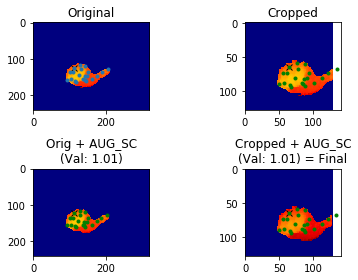


Com_Orig:  [156.51962 110.09669 333.404  ] 
Com_Crop:  [ 64.01733  63.64397 333.404  ] 
Com_Crop_Aug:  [ 63.560806  64.088394 333.404   ] 
KeyPt_Crop_Aug_XY: Max => 139.85, Min => 22.38


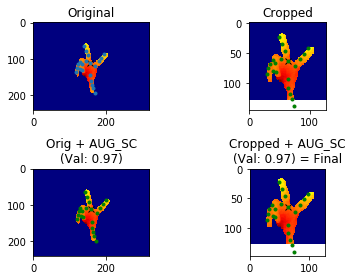


New Output Max/Min Plots -->

Com_Orig:  [111.19412 126.7601  287.876  ] 
Com_Crop:  [ 64.1479   63.81722 287.876  ] 
Com_Crop_Aug:  [ 64.1479   63.81722 287.876  ] 
KeyPt_Crop_Aug_XY: Max => 134.50, Min => 52.76


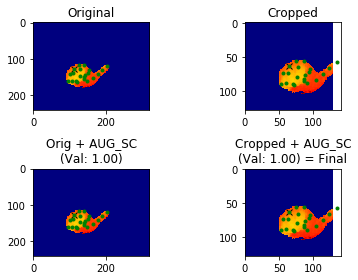


Com_Orig:  [161.2951  114.26565 331.835  ] 
Com_Crop:  [ 63.81913   63.793125 331.835   ] 
Com_Crop_Aug:  [ 64.262314  64.23613  331.835   ] 
KeyPt_Crop_Aug_XY: Max => 135.16, Min => 20.20


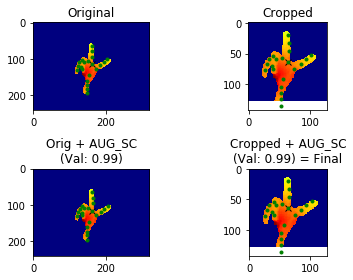

(array([[[0.59615827, 0.59615827, 0.59615827, ..., 0.59615827,
          0.59615827, 0.59615827],
         [0.59615827, 0.59615827, 0.59615827, ..., 0.59615827,
          0.59615827, 0.59615827],
         [0.59615827, 0.59615827, 0.59615827, ..., 0.59615827,
          0.59615827, 0.59615827],
         ...,
         [0.59615827, 0.59615827, 0.59615827, ..., 0.59615827,
          0.59615827, 0.59615827],
         [0.59615827, 0.59615827, 0.59615827, ..., 0.59615827,
          0.59615827, 0.59615827],
         [0.59615827, 0.59615827, 0.59615827, ..., 0.59615827,
          0.59615827, 0.59615827]]], dtype=float32),
 array([-0.1401023 , -0.49278536,  0.55333424,  0.15703982, -0.18041208,
         0.00335649,  0.29312274, -0.04506233, -0.24270791,  0.39321837,
         0.05471398, -0.4292453 ,  0.48143756,  0.14291431, -0.6003047 ,
         0.        ,  0.        ,  0.        ,  0.0104237 ,  0.25853854,
        -0.26284686,  0.00524401,  0.4188755 , -0.44909114, -0.01253232,
         0.5503

In [48]:
#### data testing ####

### Test Max/Min Value of Skeleton
### Expect: Max <= 1; Min >= -1
print("Outputs Shape: ", old_outputs.shape, new_outputs.shape)

old_outputs_xy = old_outputs.reshape(-1, 21, 3)[:, :, :2].reshape(-1, 42)
new_outputs_xy = new_outputs.reshape(-1, 21, 3)[:, :, :2].reshape(-1, 42)

#old_outputs_xy = old_outputs[:, :2]
out_old_max, out_old_argmax = old_outputs_xy.max(axis=1).max(), old_outputs_xy.max(axis=1).argmax()
out_old_min, out_old_argmin = old_outputs_xy.min(axis=1).min(), old_outputs_xy.min(axis=1).argmin()

#new_outputs_xy = new_outputs[:, :2]
out_new_max, out_new_argmax = new_outputs_xy.max(axis=1).max(), new_outputs_xy.max(axis=1).argmax()
out_new_min, out_new_argmin = new_outputs_xy.min(axis=1).min(), new_outputs_xy.min(axis=1).argmin()

print("Old Outputs Max/Min: ", out_old_max, out_old_min)
print("New Outputs Max/Min: ", out_new_max, out_new_min)

old_dataset_obj_no_aug.transform.transforms[0].debug_mode = True
new_dataset_obj_no_aug.transform.transforms[2].debug_mode = True

print("\nOld Output Max/Min Plots -->")
old_dataset_obj_no_aug[out_old_argmax]
old_dataset_obj_no_aug[out_old_argmin]

print("\nNew Output Max/Min Plots -->")
new_dataset_obj_no_aug[out_new_argmax]
new_dataset_obj_no_aug[out_new_argmin]

In [49]:
### Test 2 Trans Tests

#### data loading ####
data_aug = [AugType.AUG_TRANS]
old_transforms = transforms.Compose([
            DeepPriorXYTransform(aug_mode_lst=data_aug),
            ToTuple(extract_type='depth_joints'),
])
new_transforms = transforms.Compose([
            JointReshaper(**trnsfrm_base_params),
            DepthCropper(**trnsfrm_base_params),
            DepthAndJointsAugmenter(aug_mode_lst=data_aug,**trnsfrm_base_params),
            DepthStandardiser(**trnsfrm_base_params),
            JointCentererStandardiser(**trnsfrm_base_params),
            ToTuple(extract_type='depth_joints'),
])
old_dataset_obj_no_aug = MSRAHandDataset(root=data_dir, center_dir='', mode='train', 
                                           test_subject_id=0, transform=old_transforms, reduce=False,
                                           use_refined_com=False)
new_dataset_obj_no_aug = MSRAHandDataset(root=data_dir, center_dir='', mode='train', 
                                           test_subject_id=0, transform=new_transforms, reduce=False,
                                           use_refined_com=False)

### load_data ###
old_inputs, old_outputs = dataset2arrays(old_dataset_obj_no_aug)
new_inputs, new_outputs = dataset2arrays(new_dataset_obj_no_aug)

Train/Test: 67876 8499
Train/Test: 67876 8499


Loading dataset: 100%|██████████| 67876/67876 [04:30<00:00, 250.94it/s]


Outputs Shape:  (67876, 63) (67876, 63)
Old Outputs Max/Min:  1.0826188325881958 -1.027936339378357
New Outputs Max/Min:  1.1500835289209 -1.0630045622725346

Old Output Max/Min Plots -->

Com_Orig:  [112.66088 123.84505 289.588  ] 
Com_Crop:  [ 64.123314  64.26447  289.588   ] 
Com_Crop_Aug:  [ 61.021774  63.491913 289.588   ] 
KeyPt_Crop_Aug_XY: Max => 131.99, Min => 46.26


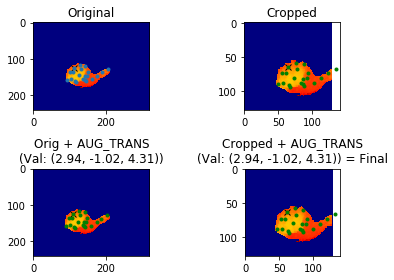


Com_Orig:  [154.94052 107.50296 334.218  ] 
Com_Crop:  [ 63.50612  64.00261 334.218  ] 
Com_Crop_Aug:  [ 63.499214  64.00264  334.218   ] 
KeyPt_Crop_Aug_XY: Max => 135.44, Min => 30.24


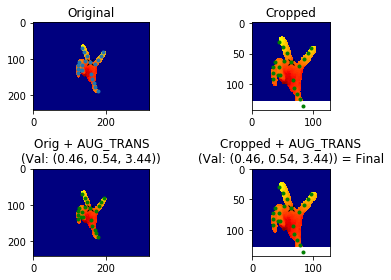


New Output Max/Min Plots -->

Com_Orig:  [150.641   117.91395 320.865  ] 
Com_Crop:  [ 64.11952   63.503212 320.865   ] 
Com_Crop_Aug:  [ 66.28412   63.060715 320.865   ] 
KeyPt_Crop_Aug_XY: Max => 124.99, Min => 17.81


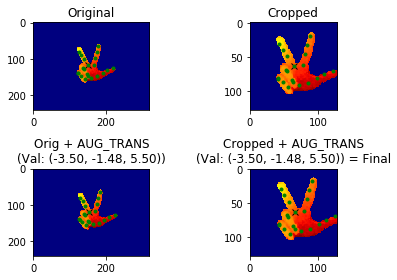


Com_Orig:  [152.70917  65.6399  391.109  ] 
Com_Crop:  [ 64.21767   64.145584 391.109   ] 
Com_Crop_Aug:  [ 64.73204   62.596024 391.109   ] 
KeyPt_Crop_Aug_XY: Max => 125.75, Min => 39.92


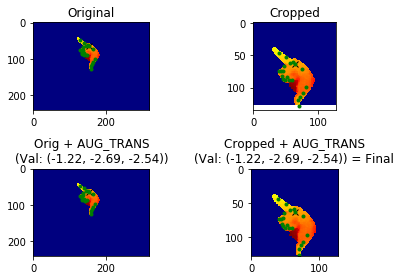

(array([[[0.51471215, 0.51471215, 0.51471215, ..., 0.51471215,
          0.51471215, 0.51471215],
         [0.51471215, 0.51471215, 0.51471215, ..., 0.51471215,
          0.51471215, 0.51471215],
         [0.51471215, 0.51471215, 0.51471215, ..., 0.51471215,
          0.51471215, 0.51471215],
         ...,
         [0.51471215, 0.51471215, 0.51471215, ..., 0.51471215,
          0.51471215, 0.51471215],
         [0.51471215, 0.51471215, 0.51471215, ..., 0.51471215,
          0.51471215, 0.51471215],
         [0.51471215, 0.51471215, 0.51471215, ..., 0.51471215,
          0.51471215, 0.51471215]]], dtype=float32),
 array([ 0.30104665, -0.46794057,  0.4878932 ,  0.18401811, -0.09578924,
        -0.07533678, -0.00974923, -0.00409917, -0.29380663, -0.15559085,
         0.06357608, -0.45765673, -0.29209958,  0.1146345 , -0.60571673,
         0.01221923,  0.02691767,  0.02542341, -0.2444383 , -0.16009557,
        -0.1469768 , -0.21381658, -0.34192338,  0.0064134 , -0.06524539,
        -0.3267

In [50]:
#### data testing ####

### Test Max/Min Value of Skeleton
### Expect: Max <= 1; Min >= -1
print("Outputs Shape: ", old_outputs.shape, new_outputs.shape)

old_outputs_xy = old_outputs.reshape(-1, 21, 3)[:, :, :2].reshape(-1, 42)
new_outputs_xy = new_outputs.reshape(-1, 21, 3)[:, :, :2].reshape(-1, 42)

#old_outputs_xy = old_outputs[:, :2]
out_old_max, out_old_argmax = old_outputs_xy.max(axis=1).max(), old_outputs_xy.max(axis=1).argmax()
out_old_min, out_old_argmin = old_outputs_xy.min(axis=1).min(), old_outputs_xy.min(axis=1).argmin()

#new_outputs_xy = new_outputs[:, :2]
out_new_max, out_new_argmax = new_outputs_xy.max(axis=1).max(), new_outputs_xy.max(axis=1).argmax()
out_new_min, out_new_argmin = new_outputs_xy.min(axis=1).min(), new_outputs_xy.min(axis=1).argmin()

print("Old Outputs Max/Min: ", out_old_max, out_old_min)
print("New Outputs Max/Min: ", out_new_max, out_new_min)

old_dataset_obj_no_aug.transform.transforms[0].debug_mode = True
new_dataset_obj_no_aug.transform.transforms[2].debug_mode = True

print("\nOld Output Max/Min Plots -->")
old_dataset_obj_no_aug[out_old_argmax]
old_dataset_obj_no_aug[out_old_argmin]

print("\nNew Output Max/Min Plots -->")
new_dataset_obj_no_aug[out_new_argmax]
new_dataset_obj_no_aug[out_new_argmin]

In [13]:
import yaml
from pprint import pprint

config = yaml.load(open('experiments/baseline_quick_exp_hpe.yaml'), Loader=yaml.SafeLoader)
data_loader_config = config['data_loader']
print("Data Loader Config -->")
pprint(data_loader_config)


Data Loader Config -->
{'args': {'batch_size': 128,
          'data_aug': [0, 1],
          'data_dir': 'datasets/hand_pose_action',
          'dataset_type': 'train',
          'debug': False,
          'num_workers': 8,
          'pca_components': 30,
          'pca_data_aug': [0, 1],
          'pca_overwrite_cache': False,
          'preload_depth': False,
          'reduce': False,
          'shuffle': True,
          'use_msra': True,
          'use_pca_cache': True,
          'validation_split': 0.2},
 'type': 'DepthJointsDataLoader'}
